In [429]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

## Titanic Competition

https://www.kaggle.com/c/titanic
    
## Data Dictionary
`Variable` `DefinitionKey`<br>
**survival**	Survival	0 = No, 1 = Yes
**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
**sex**	Sex	
**Age**	Age in years	
**sibsp**	# of siblings / spouses aboard the Titanic	
**parch**	# of parents / children aboard the Titanic	
**ticket**	Ticket number	
**fare**	Passenger fare	
**cabin**	Cabin number	
**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


**Variable Notes**<br>
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>

sibsp: The dataset defines family relations in this way<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)<br>

parch: The dataset defines family relations in this way<br>
Parent = mother, father <br>
Child = daughter, son, stepdaughter, stepson <br>
Some children travelled only with a nanny, therefore parch=0 for them.<br>

In [430]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm
from sklearn.model_selection import GridSearchCV 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [431]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')

In [432]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [433]:
test = pd.read_csv('data/test.csv', index_col='PassengerId')

In [434]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


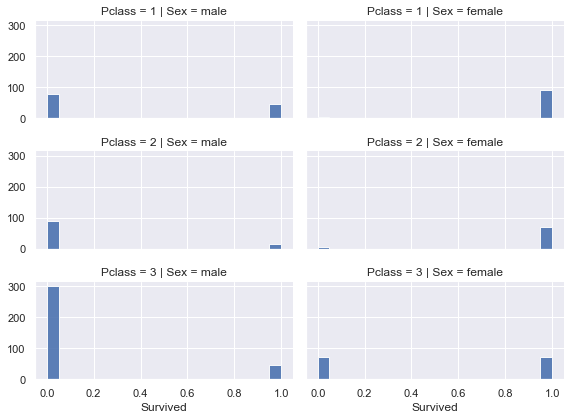

In [435]:
grid = sns.FacetGrid(train, col='Sex', row='Pclass', height=2, aspect=2)
grid.map(plt.hist, 'Survived', alpha=0.9, bins = 20)
grid.add_legend();

In [436]:
pd.crosstab(train['Survived'], train['Sex'], margins=True)

Sex,female,male,All
Survived,,,
0,81,468,549
1,233,109,342
All,314,577,891


In [437]:
train[['Sex', 'Survived']].groupby('Sex').mean().sort_values(by='Survived')

,Survived
Sex,
male,0.188908
female,0.742038


In [438]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [439]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [440]:
train[['Survived', 'Embarked']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [441]:
train[['Survived', 'Embarked', 'Pclass']].groupby(['Embarked', 'Pclass']).agg({'Survived': [np.mean]})

Survived
                     mean
Embarked Pclass          
C        1       0.694118
         2       0.529412
         3       0.378788
Q        1       0.500000
         2       0.666667
         3       0.375000
S        1       0.582677
         2       0.463415
         3       0.189802

In [442]:
train[['Embarked', 'Pclass']].value_counts().sort_index()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
dtype: int64

##  Missing Ages

There are a number of missing ages in the data.

In [443]:
train['Age'].isna().sum()

177

We could impute the median (or mean) age for everyone that is missing, but this obscures some of the relationship that exists between other varaibles in the data.  For example, the following graph shows that if you are in `Pclass` 3 and are `male` you age with skew younger than if you are in `Pclass` 1 and `male`.  

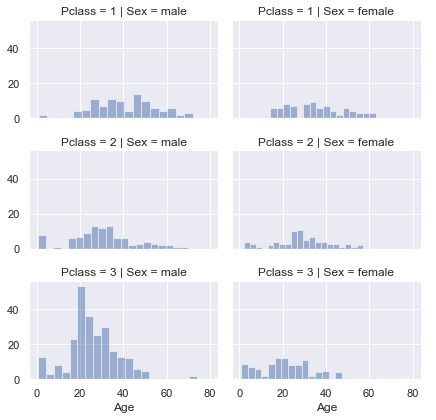

In [444]:
grid = sns.FacetGrid(train, col='Sex', row='Pclass', height=2, aspect=1.5)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend();

### Idea 
Impute `Age` using mean/median where we group by `Pclass` and `Sex`.  

In [445]:
ages = train[['Age', 'Pclass', 'Sex']].groupby(['Pclass', 'Sex']).median()

In [446]:
ages

Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0

In [447]:
ages.loc[(2, 'female')]

Age    28.0
Name: (2, female), dtype: float64

In [448]:
#  Do the imputation for the missing Age data
#  Don't forget to do it for the testing data too, but we will use the 
#  medians computed from the training data (in a similar fashion that 
#  scikit-learn would do using a transformer)
'''
for df in [train, test]:
    for row in df.itertuples(): 
        if np.isnan(row.Age):
            df.loc[row.Index, 'Age'] = ages.loc[(row.Pclass, row.Sex)].Age
'''

"\nfor df in [train, test]:\n    for row in df.itertuples(): \n        if np.isnan(row.Age):\n            df.loc[row.Index, 'Age'] = ages.loc[(row.Pclass, row.Sex)].Age\n"

In [449]:
train[train['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


##  A custom "GroupImputer"

We can generalize the idea above to create a custom transformer, which would also allow us to use the transformer inside of a pipeline if we wanted (assuming the input it receives is a DataFrame).  

In [450]:
from sklearn.base import BaseEstimator, TransformerMixin

class GroupImputer(BaseEstimator, TransformerMixin):
    '''Imputes a column based on an aggregation function supplied by
    the user, grouping data based on another set of columns in 
    the DataFrame.
    
    col_to_impute :  A string for a column name in the DataFrame.
    grouper       :  A list of column names to use to groupby and 
                     perform the imputation.
    agg_func      :  A numpy aggregation function (default is np.median).
    '''
    def __init__(self, col_to_impute, grouper, agg_func=np.median):
        self.col_to_impute = col_to_impute
        self.grouper = grouper
        self.agg_func = agg_func
    
    def fit(self, X, y=None):
        self.data = X[self.grouper + [self.col_to_impute]].groupby(self.grouper).agg({self.col_to_impute: self.agg_func})
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for row in X_copy.itertuples():
            if np.isnan(row._asdict()[self.col_to_impute]):
                tup = tuple([row._asdict()[k] for k in self.grouper])
                X_copy.loc[row.Index, self.col_to_impute] = self.data.loc[tup][self.col_to_impute]
        return X_copy

In [451]:
age_imputer = GroupImputer('Age', ['Pclass', 'Sex'])

In [452]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')

In [453]:
train['Age'].isna().sum()

177

In [454]:
age_imputer.fit(train)

GroupImputer(col_to_impute='Age', grouper=['Pclass', 'Sex'])

In [455]:
age_imputer.data

Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0

In [456]:
train = age_imputer.transform(train)
test = age_imputer.transform(test)

In [457]:
train['Age'].isna().sum()

0

In [458]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##  Relation of `Survived` and `Pclass`

In [459]:
pd.crosstab(train['Survived'], train['Pclass'], margins=True)

Pclass,1,2,3,All
Survived,,,,
0,80,97,372,549
1,136,87,119,342
All,216,184,491,891


In [460]:
train[['Survived', 'Pclass']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


##  Gender prediction

What if we simply predict survival based on gender?  If you're `female`, you survive, but not if you are `male`.  

In [461]:
y_gender_pred = (train['Sex'] == 'female').astype(int)

In [462]:
(y_gender_pred == train['Survived']).mean()

0.7867564534231201

So we can get about 78% accuracy (on the training data) from this simple prediction.  Thus we should be able to do better (one hopes!) by adding in more features.  

## Fare data?

In [463]:
train['Fare'].isna().sum()

0

In [464]:
test['Fare'].isna().sum()

1

In [465]:
test['Fare'] = test['Fare'].fillna(train['Fare'].median())

In [466]:
test['Fare'].isna().sum()

0

## Embarkation data??

In [467]:
train['Embarked'].count()

889

In [468]:
len(train)

891

In [469]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [470]:
test['Embarked'].count()

418

In [471]:
mostFrequentPort = train['Embarked'].mode()[0]

In [472]:
train[train['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [473]:
for df in [train, test]:
    df['Embarked'] = df['Embarked'].fillna(mostFrequentPort)

In [474]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 123.5+ KB


In [475]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 55.9+ KB


In [476]:
train = train.drop('Cabin', axis=1)
test = test.drop('Cabin', axis=1)

In [477]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 116.6+ KB


##  Titles in names??

In [478]:
train['Name'].values

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [479]:
for df in [train, test]:
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')

In [480]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


In [481]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Don           1
Jonkheer      1
Sir           1
Mme           1
Capt          1
Ms            1
Countess      1
Lady          1
Name: Title, dtype: int64

In [482]:
for df in [train, test]:
    df['Title'] = df['Title'].replace(['Dr', 'Rev', 'Major', 'Col', 'Sir', 'Countess', 
                                      'Don', 'Lady', 'Capt', 'Jonkheer'], 'Special')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Mme'], 'Mrs')

In [483]:
train['Title'].value_counts()

Mr         517
Miss       185
Mrs        126
Master      40
Special     23
Name: Title, dtype: int64

In [484]:
train.drop(columns=['Name','Ticket'], inplace=True)
test.drop(columns=['Name','Ticket'], inplace=True)

In [486]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr
2,1,1,female,38.0,1,0,71.2833,C,Mrs
3,1,3,female,26.0,0,0,7.9250,S,Miss
4,1,1,female,35.0,1,0,53.1000,S,Mrs
5,0,3,male,35.0,0,0,8.0500,S,Mr


## Predictions!

In [487]:
y_train = train.pop('Survived')

In [319]:
features = Pipeline([
    ('get_features', ColumnTransformer([
                            ('categorical', OneHotEncoder(handle_unknown='ignore'), ['Sex', 'Embarked', 'Title', 'Pclass']),
                            ('numeric' ,StandardScaler(), ['Age', 'SibSp', 'Parch', 'Fare'])
                            ])
    ),
    ('poly', PolynomialFeatures(degree=3, interaction_only=True))
])  

In [321]:
lgr = Pipeline([
    ('features', features),
    ('lgr', GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C':np.logspace(-2,2,10)}, cv=5))
])
lgr.fit(train, y_train)
y_predicted_train = lgr.predict(train)

print(f'Training Acc : {accuracy_score(y_train, y_predicted_train)}')

Training Acc : 0.8428731762065096


In [322]:
sgd = Pipeline([
    ('features', features),
    ('SGD', GridSearchCV(SGDClassifier(), param_grid={'alpha':np.logspace(-2,5,10)}, cv=5))
])
sgd.fit(train, y_train)
y_predicted_train = sgd.predict(train)

print(f'Training Acc : {accuracy_score(y_train, y_predicted_train)}')

Training Acc : 0.8372615039281706


In [323]:
rf_clf = Pipeline([
    ('features', features),
    ('rf_clf',GridSearchCV(RandomForestClassifier(), param_grid={'max_depth': [3,6,9], 'min_samples_split': [5,10]}, cv=5))
])
rf_clf.fit(train, y_train)
y_predicted_train = rf_clf.predict(train)

print(f'Training Acc : {accuracy_score(y_train, y_predicted_train)}')

Training Acc : 0.9158249158249159


In [324]:
svc = Pipeline([
    ('features', features),
    ('svc',GridSearchCV(SVC(), param_grid={'C':np.logspace(-2,4,10), 'class_weight':[None, 'balanced']}, cv=5))
])
svc.fit(train, y_train)
y_predicted_train = svc.predict(train)

print(f'Training Acc : {accuracy_score(y_train, y_predicted_train)}')

Training Acc : 0.8540965207631874


In [325]:
perceptron = Pipeline([
    ('features', features),
    ('clf',GridSearchCV(Perceptron(), param_grid={'penalty':[None, 'l1', 'l2'], 'alpha':np.logspace(-3,1,10)}, verbose=1, cv=5))
])
perceptron.fit(train, y_train)
y_predicted_train = perceptron.predict(train)

print(f'Training Acc : {accuracy_score(y_train, y_predicted_train)}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Training Acc : 0.8260381593714927


In [326]:
knc = Pipeline([
    ('features', features),
    ('clf',GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors':[2,3,4,5,6,7,8,10,11,12,16,17,20]}, verbose=1, cv=5))
])
knc.fit(train, y_train)
y_predicted_train = knc.predict(train)

print(f'Training Acc : {accuracy_score(y_train, y_predicted_train)}')

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Training Acc : 0.8529741863075196


In [488]:
lgbm = Pipeline([
    ('features', features),
    ('clf',GridSearchCV(lightgbm.LGBMClassifier(), param_grid = {
                                                                    'n_estimators': [300,400, 700],
                                                                    'max_depth': [4,7,10,15],
                                                                    'num_leaves': [20,30,40,50],
                                                                    'colsample_bytree': [0.5, 0.7]
                                                                }, verbose=1, cv=5))
])
lgbm.fit(train, y_train)
y_predicted_train = lgbm.predict(train)

print(f'Training Acc : {accuracy_score(y_train, y_predicted_train)}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Training Acc : 0.9640852974186308


In [489]:
test.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,Mr
893,3,female,47.0,1,0,7.0000,S,Mrs
894,2,male,62.0,0,0,9.6875,Q,Mr


In [490]:
test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64

In [491]:
train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Mr
2,1,female,38.0,1,0,71.2833,C,Mrs
3,3,female,26.0,0,0,7.9250,S,Miss


In [494]:
from datetime import datetime 
filetime = datetime.now().strftime('%Y/%m/%d-%H:%M')
#test = test.drop('Survived', axis=1)
test['Survived']= lgbm.predict(test)
test[['Survived']].to_csv('submission.csv')